<a href="https://colab.research.google.com/github/xandrisx/pytorch-weather-deep-learning/blob/main/pytorch_weather_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#Mappák létrehozásáért felelős kód
import os

# Időjárási kategóriák listája
weather_categories = ['cloudy', 'rainy', 'sunny', 'sunrise']

# Alap mappa útvonala
base_dir = '/content/weather_images'

# Mappák létrehozása
for category in weather_categories:
    category_dir = os.path.join(base_dir, category)
    os.makedirs(category_dir, exist_ok=True)
    print(f'Mappa létrehozva: {category_dir}')

print('\nÖsszes mappa sikeresen létrehozva.')



Mappa létrehozva: /content/weather_images/cloudy
Mappa létrehozva: /content/weather_images/rainy
Mappa létrehozva: /content/weather_images/sunny
Mappa létrehozva: /content/weather_images/sunrise

Összes mappa sikeresen létrehozva.


In [5]:
#Ez a kód megjeleníti, hogy hány db fájlt tartalmaznak az adott mappák
import os

base_dir = '/content/weather_images'
weather_categories = ['cloudy', 'rainy', 'sunny', 'sunrise']

for category in weather_categories:
    category_dir = os.path.join(base_dir, category)
    files = os.listdir(category_dir)
    print(f"{category}: {len(files)} fájl")


cloudy: 300 fájl
rainy: 215 fájl
sunny: 253 fájl
sunrise: 357 fájl


In [6]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Adatok betöltése és előkészítése
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data_dir = "/content/weather_images"
dataset = ImageFolder(data_dir, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Modell definiálása
model = torchvision.models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Veszteségfüggvény és optimalizáló
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Tanítás
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

# Modell mentése
torch.save(model.state_dict(), 'weather_classification_model2.pth')
print("Modell sikeresen elmentve: weather_classification_model.pth")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 139MB/s]


Epoch [1/50], Loss: 0.3504
Epoch [2/50], Loss: 0.3048
Epoch [3/50], Loss: 0.2072
Epoch [4/50], Loss: 0.2973
Epoch [5/50], Loss: 0.2476
Epoch [6/50], Loss: 0.2589
Epoch [7/50], Loss: 0.2293
Epoch [8/50], Loss: 0.2118
Epoch [9/50], Loss: 0.2262
Epoch [10/50], Loss: 0.1729
Epoch [11/50], Loss: 0.2388
Epoch [12/50], Loss: 0.2022
Epoch [13/50], Loss: 0.1096
Epoch [14/50], Loss: 0.1024
Epoch [15/50], Loss: 0.1052
Epoch [16/50], Loss: 0.0791
Epoch [17/50], Loss: 0.0883
Epoch [18/50], Loss: 0.2247
Epoch [19/50], Loss: 0.3508
Epoch [20/50], Loss: 0.1826
Epoch [21/50], Loss: 0.1095
Epoch [22/50], Loss: 0.0616
Epoch [23/50], Loss: 0.1024
Epoch [24/50], Loss: 0.1563
Epoch [25/50], Loss: 0.1452
Epoch [26/50], Loss: 0.1367
Epoch [27/50], Loss: 0.1148
Epoch [28/50], Loss: 0.1352
Epoch [29/50], Loss: 0.1814
Epoch [30/50], Loss: 0.1526
Epoch [31/50], Loss: 0.0846
Epoch [32/50], Loss: 0.0815
Epoch [33/50], Loss: 0.1204
Epoch [34/50], Loss: 0.0597
Epoch [35/50], Loss: 0.0776
Epoch [36/50], Loss: 0.1794
E

In [1]:
#teszteléshez új mappák létrehozása, amely jármű fedélzeti kamerák felvételeit tartalmazza
import os

weather_categories = ['cloudy', 'rainy', 'sunny', 'sunrise']
base_dir = '/content/new_weather_images'
[os.makedirs(os.path.join(base_dir, category), exist_ok=True) for category in weather_categories]
print('Új mappák sikeresen létrehozva a kiértékeléshez.')


Új mappák sikeresen létrehozva a kiértékeléshez.


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-10-fc4a455345c4>:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

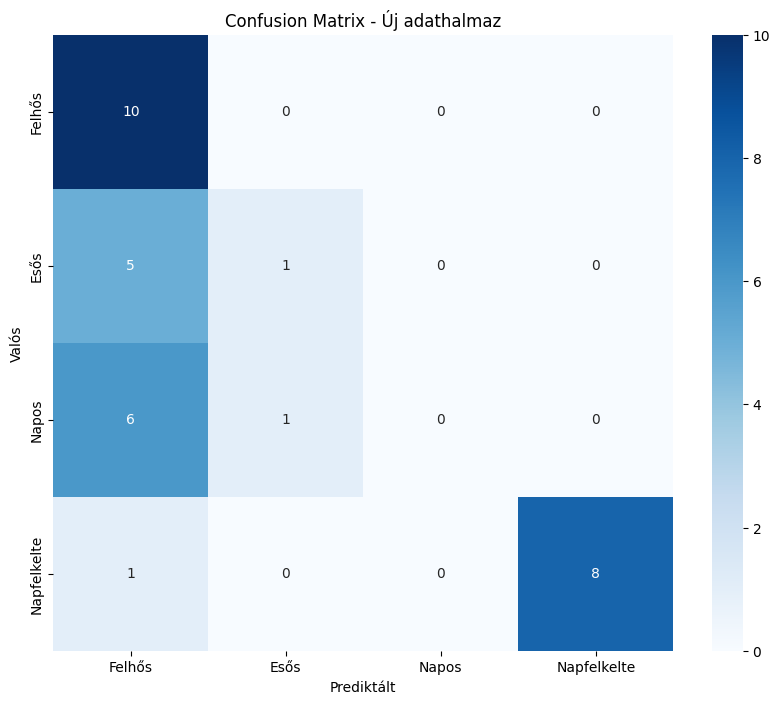

Accuracy az új adathalmazon: 0.59
Felhős pontossága: 1.00
Esős pontossága: 0.17
Napos pontossága: 0.00
Napfelkelte pontossága: 0.89


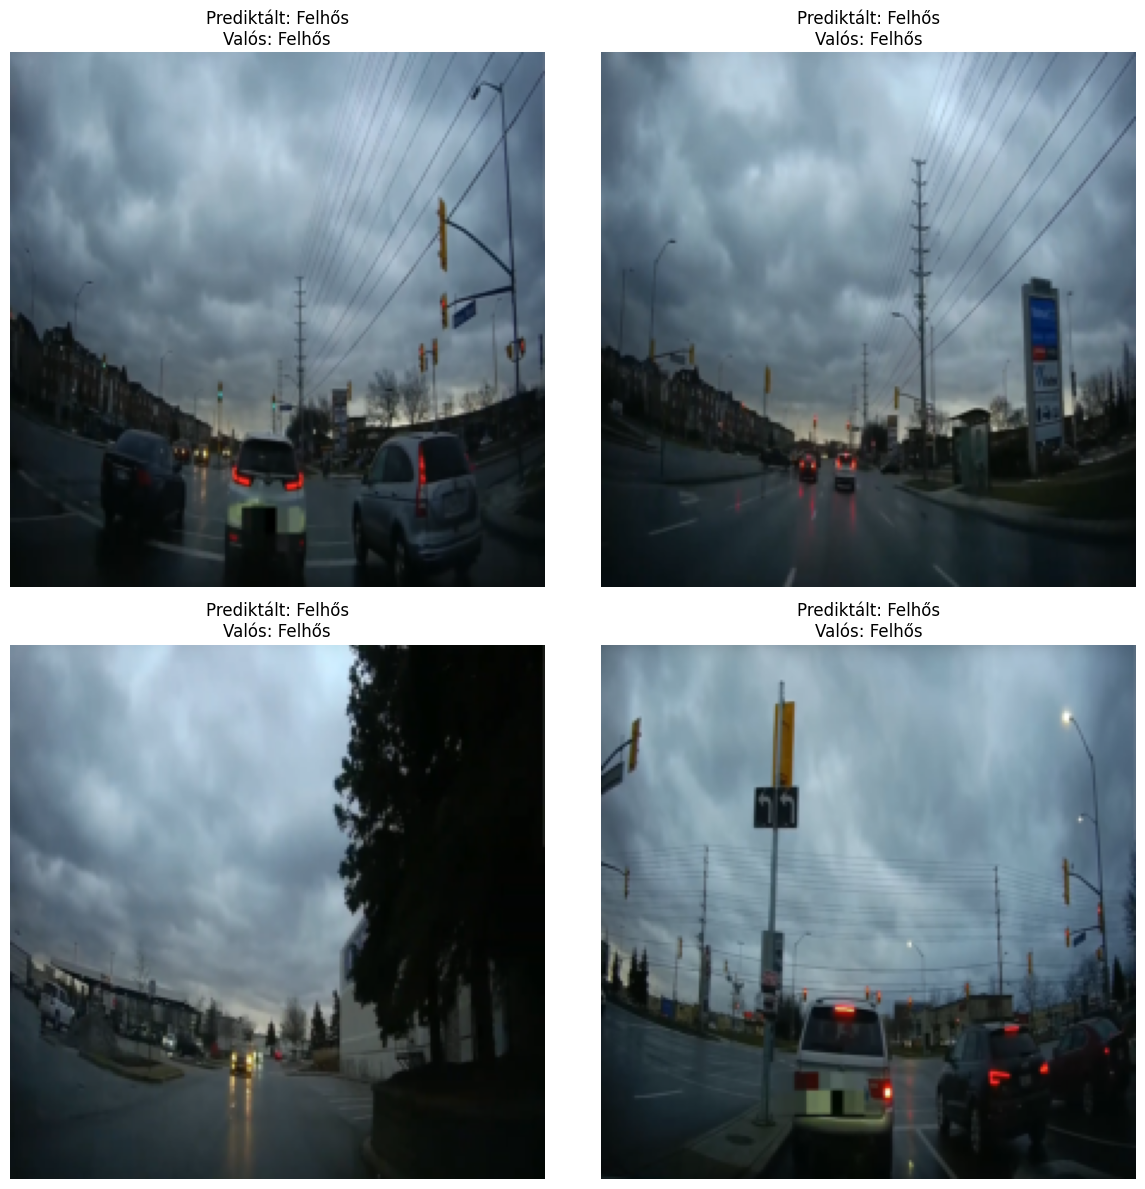

In [10]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random

# Adatok betöltése és előkészítése
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

new_data_dir = "/content/new_weather_images"
new_dataset = ImageFolder(new_data_dir, transform=transform)
new_loader = DataLoader(new_dataset, batch_size=32, shuffle=True)

# Modell betöltése
model = torchvision.models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)
model.load_state_dict(torch.load('weather_classification_model2.pth'))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

# Kiértékelés
all_preds = []
all_labels = []
sample_images = []
sample_preds = []
sample_labels = []

with torch.no_grad():
    for inputs, labels in new_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # 4 véletlenszerű kép kiválasztása
        if len(sample_images) < 4:
            for i in range(min(4 - len(sample_images), len(inputs))):
                sample_images.append(inputs[i].cpu())
                sample_preds.append(preds[i].item())
                sample_labels.append(labels[i].item())

        if len(sample_images) == 4:
            break

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
class_names = ['Felhős', 'Esős', 'Napos', 'Napfelkelte']
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Prediktált')
plt.ylabel('Valós')
plt.title('Confusion Matrix - Új adathalmaz')
plt.show()

# Accuracy kiszámítása
accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy az új adathalmazon: {accuracy:.2f}')

# Osztályonkénti pontosság
class_accuracy = cm.diagonal() / cm.sum(axis=1)
for i, acc in enumerate(class_accuracy):
    print(f'{class_names[i]} pontossága: {acc:.2f}')

# 4 véletlenszerű kép megjelenítése
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
for i, ax in enumerate(axs.flat):
    img = sample_images[i].permute(1, 2, 0)
    img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    img = img.clip(0, 1)
    ax.imshow(img)
    ax.set_title(f'Prediktált: {class_names[sample_preds[i]]}\nValós: {class_names[sample_labels[i]]}')
    ax.axis('off')

plt.tight_layout()
plt.show()
